In [370]:
import pandas as pd
import numpy as np
import seaborn as sns
from os.path import exists
import datetime
import os
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import torchvision
import torch
import torch.nn as nn
import glob
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.optim import Adam
from torch.autograd import Variable
from PIL import Image
from numpy import asarray
from tqdm.notebook import tqdm
import requests
from sklearn.metrics import classification_report
from matplotlib import gridspec

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if not os.getcwd().endswith('data'):
    os.chdir('C:\\Users\\ASUS Zephyrus\\Desktop\\INR\\data')

In [371]:
def train_epoch(train_generator, model, loss_function, optimizer, callback = None):
    epoch_loss = 0
    total = 0
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        batch_loss = train_on_batch(model, batch_of_x.to(device), batch_of_y.to(device), optimizer, loss_function)
        
        if callback is not None:
            callback(model, batch_loss)
            
        epoch_loss += batch_loss*len(batch_of_x)
        total += len(batch_of_x)
    
    return epoch_loss/total

def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    model.train()
    model.zero_grad()
    
    output = model(x_batch.to(device))
    
    #loss = loss_function(output, y_batch.to(device))
    loss = loss_function(output, y_batch.to(device)) #.squeeze_()
    loss.backward()

    optimizer.step()
    return loss.cpu().item()

def trainer(count_of_epoch, 
            batch_size, 
            dataset,
            model, 
            loss_function,
            optimizer,
            lr = 0.001,
            weight_decay=1e-5,
            callback = None):

    loss_list=[]
    iteration_list=[]
    
    loss_list_t=[]
    iteration_list_t=[]
    
    optima = optimizer(model.parameters(), lr=lr, weight_decay = 1e-5)
    
    iterations = tqdm(range(count_of_epoch), desc='epoch')
    iterations.set_postfix({'train epoch loss': np.nan})
    for it in iterations:
        batch_generator = tqdm(
            torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True), 
            leave=False, total=len(dataset)//batch_size+(len(dataset)%batch_size> 0))
        
        epoch_loss = train_epoch(train_generator=batch_generator, 
                    model=model, 
                    loss_function=loss_function, 
                    optimizer=optima, 
                    callback=callback)
        loss_list.append(epoch_loss)
        iteration_list.append(it)
        
        iterations.set_postfix({'train epoch loss': epoch_loss})
        
        #TEST
        batch_generator = torch.utils.data.DataLoader(dataset = test_ds, 
                                              batch_size=batch_size)
            
        test_loss = 0
        for it, (x_batch, y_batch) in enumerate(batch_generator):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            output = model(x_batch)

            test_loss += loss_function(output, y_batch).cpu().item()*len(x_batch) #.squeeze_()
        loss_list_t.append(test_loss/len(test_ds))
        #iteration_list_t.append(it)
    

    # visualization loss 
    plt.plot(iteration_list,loss_list, label='train')
    plt.plot(iteration_list, loss_list_t, label='test')
    plt.xlabel("Number of epoch")
    plt.ylabel("Loss")
    plt.title("CNN: Loss vs Number of epoch")
    plt.legend()
    plt.show()  

(164500, 32)


Text(0.5, 0, 'Время, мкс')

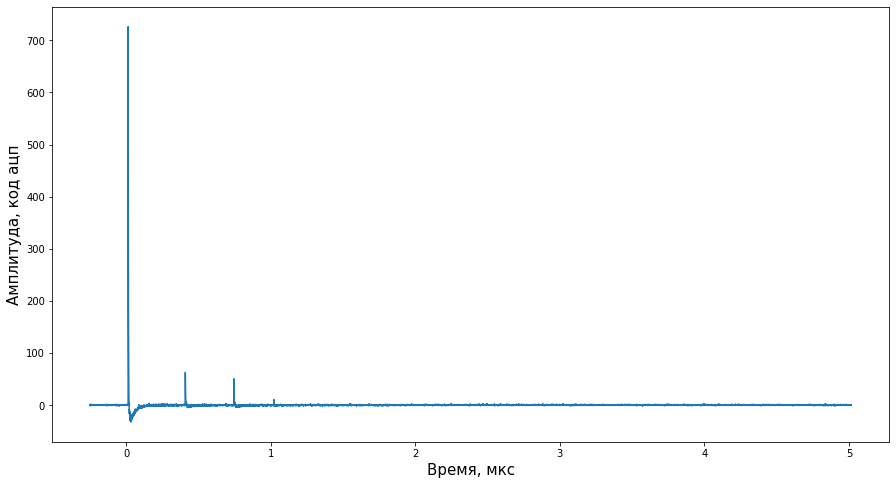

In [277]:
names = [name for i in range(1, 17) for name in ['d8_' + str(i), 'd5_' + str(i)]]
osc = pd.read_csv('osc/osc1318_10-06.21', delim_whitespace=True, names=names, index_col=0)
resampled = osc#.resample(10).mean()
plt.figure(figsize=(15, 8))
sns.lineplot(x=(resampled.index-7800)*32e-6, y=resampled['d8_1'])
#plt.ticklabel_format(style='sci', scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
#plt.semilogy()
print(resampled.shape)
plt.ylabel('Амплитуда, код ацп', fontsize = 15)
plt.xlabel('Время, мкс', fontsize = 15)

Text(0.5, 0, 'Время, мкс')

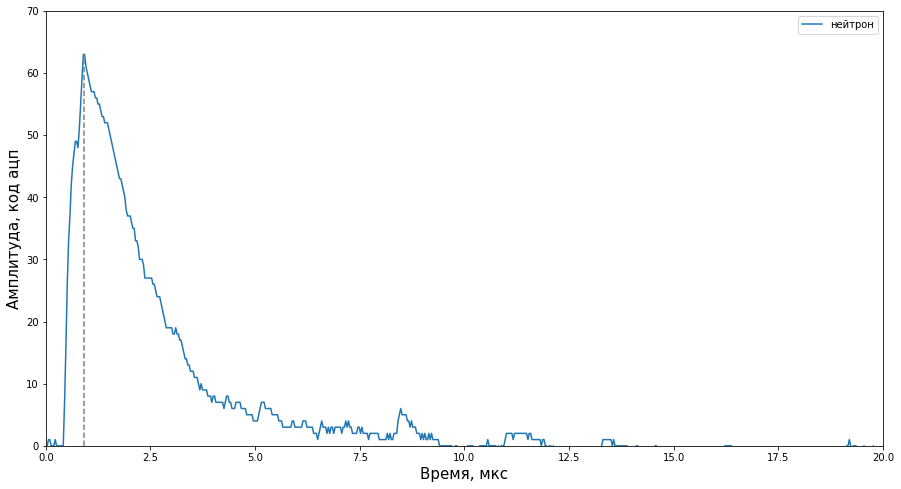

In [8]:
plt.figure(figsize=(15, 8))
sns.lineplot(x=(resampled.index-7800)*32e-3 - 408, y=resampled['d8_1'], label='нейтрон')
plt.plot([0.92, 0.92], [0, 63],"--", color="gray")
plt.xlim(0, 20)
plt.ylim(0,70)
plt.legend()
#plt.xlim(0, 15)
plt.ylabel('Амплитуда, код ацп', fontsize = 15)
plt.xlabel('Время, мкс', fontsize = 15)

Text(0.5, 0, 'Время, мкс')

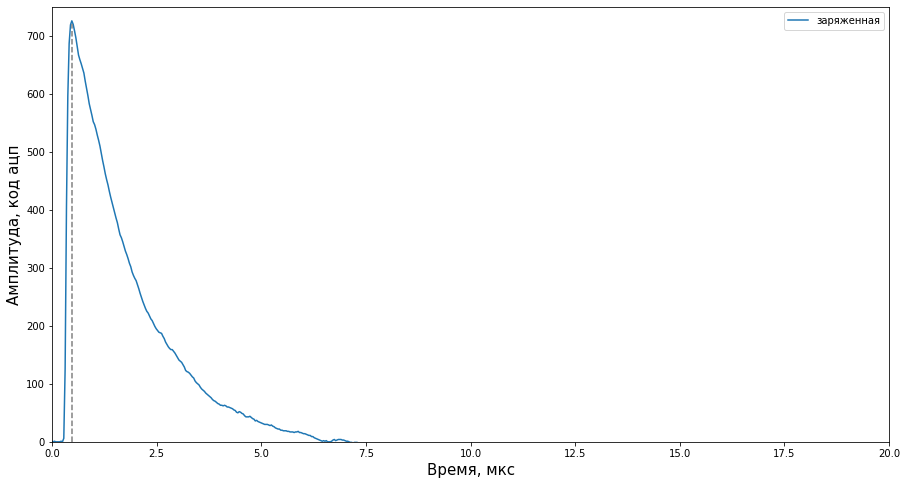

In [9]:
plt.figure(figsize=(15, 8))
sns.lineplot(x=(resampled.index-7800)*32e-3 - 13, y=resampled['d8_1'], label='заряженная')
plt.plot([0.47, 0.47], [0, 720],"--", color="gray" )
plt.xlim(0, 20)
plt.ylim(0,750)
plt.legend()
#plt.xlim(0, 15)
plt.ylabel('Амплитуда, код ацп', fontsize = 15)
plt.xlabel('Время, мкс', fontsize = 15)

# Создание выборки

In [583]:
names = [name for i in range(0, 17) for name in ['A' + str(i)]]
osc = pd.read_csv('F:\\Data\\single_osc_04-09.22', delim_whitespace=True, names=names)
df = osc[osc.A0!='-']
ei = np.array(df)
index = ei[:,0]
ei = np.delete(ei, 0, 1)
ei = np.array(ei, dtype = int)

In [584]:
max_el = []
max_index = []
max_index_det = []
front = []
size_sob = 256
charged = []
adc_2 = []

m = 0
for i in range(0,ei.shape[0],size_sob):
    max_el.append(np.max(np.max(ei[i:i+size_sob], axis=0)))           # значение макс амплитуды
    max_index.append(np.argmax(ei[i:i+size_sob], axis=0))             # индекс макс амплитуды
    #max_index_det.append(np.argmax(np.max(ei[i:i+128], axis=0))) # номер сработавшего детектора (j)
    
    j = np.argmax(np.max(ei[i:i+size_sob], axis=0))
    charged.append(ei[i:i+size_sob:, j])
    k1 = max_index[m][j]
    while(ei[k1+size_sob*m][j] > 2):
        k1-=1
    front.append(max_index[m][j]-k1)
    adc_2.append(k1)
    m+=1
    
charged = np.array(charged, dtype='int')
front = np.array(front)
adc_2 = np.array(adc_2)
max_index = np.array(max_index)
max_el = np.array(max_el)
max_el.shape, max_index.shape, front.shape, charged.shape, adc_2.shape

((3068,), (3068, 16), (3068,), (3068, 256), (3068,))

In [585]:
front1 = front*32e-3
x_otob = []
y_otob = []
k_otob = []
fr1 = []

for i in range(front1.shape[0]):
    if(front1[i] < 0.49):
        y_otob.append(charged[i][adc_2[i]:adc_2[i]+38])
        k_otob.append(adc_2[i])
        fr1.append(front1[i])
    else:
        x_otob.append(charged[i]) #отброшенные по времени нарастания фронта

fr1 = np.array(fr1)
x_otob = np.array(x_otob)
k_otob = np.array(k_otob)
y_otob = np.array(y_otob)
x_otob.shape, y_otob.shape, k_otob.shape

((858, 256), (2210, 38), (2210,))

In [586]:
# минимальная амплитуда из выборки по заряженной компоненте
np.min(np.max(y_otob,axis=1))

15

In [587]:
# Сглаживание
charged = np.zeros((y_otob.shape[0],38))
for i in range(y_otob.shape[0]):
    y_lowess = sm.nonparametric.lowess(y_otob[i], x, frac = 0.11)
    charged[i] = y_lowess[:,1]
charged.shape, np.min(np.max(charged,axis=1))

((2210, 38), 14.0)

C:\Users\ASUS Zephyrus\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS Zephyrus\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '$N$')

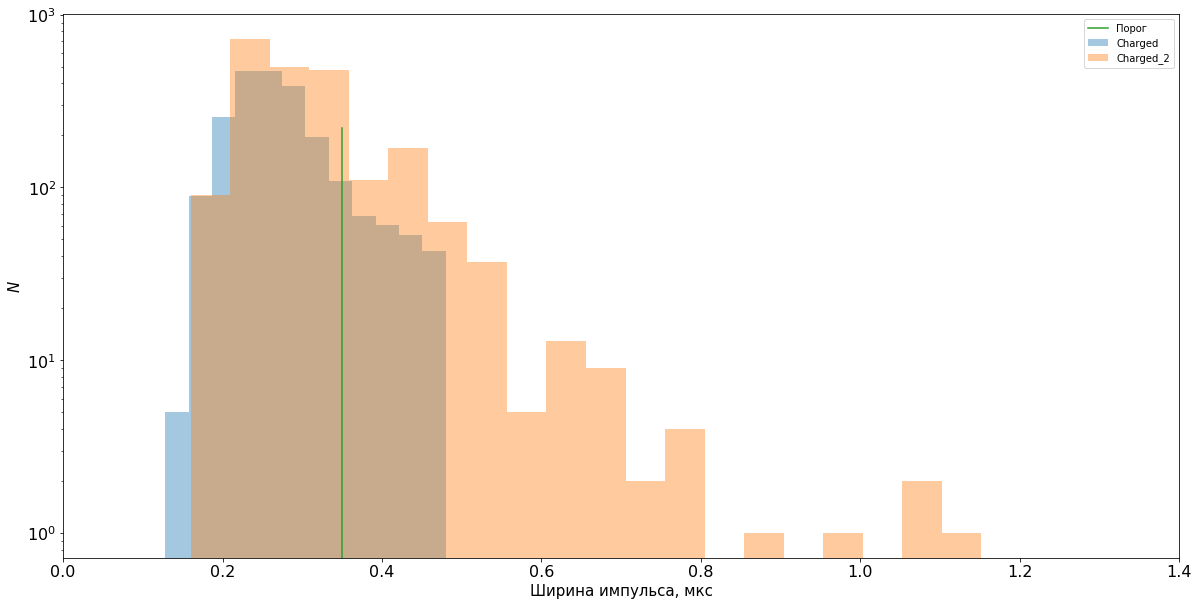

In [236]:
plt.figure(figsize=(20, 10))
sns.distplot(np.argmax(y_otob, axis=1)*32e-3, kde=False, bins=12, label='Charged')
sns.distplot(np.argmax(charged, axis=1)*32e-3, kde=False, bins=20, label='Charged_2')
plt.plot(([0.35, 0.35]),([0, 220]), label='Порог')
plt.yscale('log')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0, 1.4)
plt.legend()
plt.xlabel('Ширина импульса, мкс', fontsize = 15)
plt.ylabel("$N$", fontsize = 15)

In [588]:
y_otob = []
x_otob = []
fr1 = []
ffr = np.argmax(charged, axis=1)*32e-3

for i in range(charged.shape[0]):
    if(ffr[i] < 0.4):
        y_otob.append(charged[i])
    else:
        x_otob.append(charged[i]) #отброшенные по времени нарастания фронта

x_otob = np.array(x_otob)
y_otob = np.array(y_otob)
x_otob.shape, y_otob.shape

((308, 38), (1902, 38))

C:\Users\ASUS Zephyrus\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '$N$')

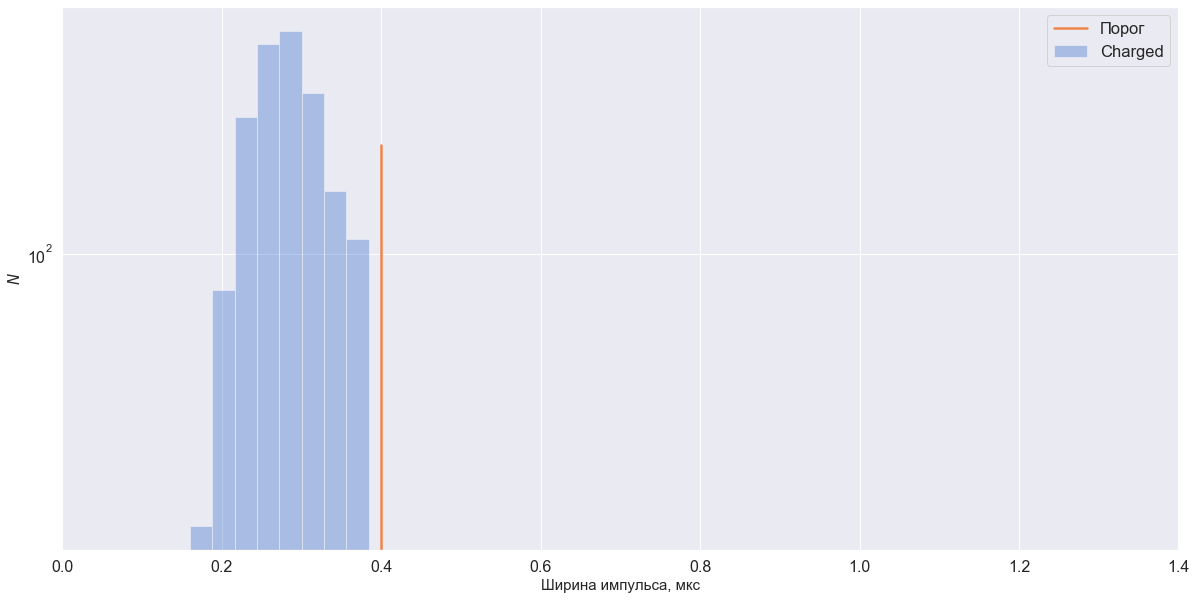

In [579]:
plt.figure(figsize=(20, 10))
sns.distplot(np.argmax(y_otob, axis=1)*32e-3, kde=False, bins=8, label='Charged')
plt.plot(([0.4, 0.4]),([0, 220]), label='Порог')
plt.yscale('log')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0, 1.4)
plt.legend()
plt.xlabel('Ширина импульса, мкс', fontsize = 15)
plt.ylabel("$N$", fontsize = 15)

In [255]:
fr1 = np.argmax(y_otob, axis=1)*32e-3
np.min(fr1), np.max(fr1)

(0.16, 0.384)

In [592]:
charged = np.copy(y_otob)
charged = charged[np.max(charged,axis=1)>=14]
charged.shape

(1902, 38)

In [593]:
np.min(np.max(charged,axis=1))

14.0

# Нейтронная компонента

In [594]:
from os import listdir
from os.path import isfile, join
mypath = 'C:\\Users\\ASUS Zephyrus\\Desktop\\INR\\data\\big_INR\\'

onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
len(onlyfiles)

16

In [595]:
names = [name for i in range(1, 17) for name in ['d8_' + str(i), 'd5_' + str(i)]]
#time_f = []
ch = []
neutron = []

time_ch = []
time_n = []
time = []

for file in onlyfiles:
    osc = pd.read_csv(mypath+file, delim_whitespace=True, names=names, index_col=0)
    for det in range(1,17):
        peaks, _ = find_peaks(osc['d8_'+ str(det)],prominence=1, height=14, width=30) # height 7
        for i in range(100): #182
            if(peaks.shape[0]>i and det!=4):
                x=np.copy(osc['d8_'+ str(det)])
                k = peaks[i]
                while(x[k]>2):
                    k-=1
                if(i==0 and (peaks[i]- k)*0.032 <0.4):
                    ch.append(x[k:k+38])
                    time_ch.append((peaks[i]- k)*0.032)
                elif(i!=0 and (peaks[i]- k)*0.032 < 1.2 and peaks[i] > 3125):  # 100 мкс 
                    neutron.append(x[k:k+38])
                    time_n.append((peaks[i]- k)*0.032)
                    
#charged = np.array(charged)
neutron = np.array(neutron)
time_ch = np.array(time_ch)
time_n = np.array(time_n)
charged.shape, neutron.shape

((1902, 38), (226, 38))

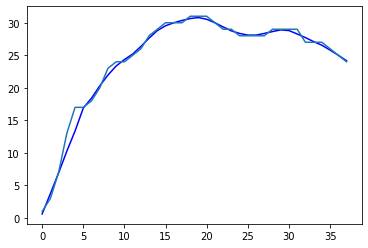

In [74]:
#x = np.arange(38)
#y_lowess = sm.nonparametric.lowess(neutron[0], x, frac = 0.2)
#plt.plot(y_lowess[:, 0], y_lowess[:, 1], 'b')  # some noise removed
#plt.plot(x,neutron[0])

In [596]:
neu = np.zeros((neutron.shape[0],38))
x = np.arange(0,38)
for i in range(neutron.shape[0]):
    y_lowess = sm.nonparametric.lowess(neutron[i], x, frac = 0.11)
    neu[i] = y_lowess[:,1]
neu.shape 

(226, 38)

In [597]:
neutron = np.copy(neu)
charged = np.copy(y_otob)
charged = charged[0:900]
charged.shape, neutron.shape, x.shape

((900, 38), (226, 38), (38,))

In [598]:
X_te = np.concatenate((charged, neutron), axis = 0)
X_te.shape

(1126, 38)

In [599]:
y = np.zeros(charged.shape[0]+neutron.shape[0])
for i in range(y.shape[0]):
    if(i < charged.shape[0]):
        y[i] = 1
    else:
        y[i] = 0
y = y.astype(int)
y.shape[0]

1126

In [286]:
k = np.argmax(X_te,axis=1)
ch = np.zeros(1902)
n = np.zeros(226)

kk = 0
kkk = 0
for i in range(k.shape[0]):
    if(y[i]==1):
        ch[kk] = k[i]*32e-3
        kk+=1
    else:
        n[kkk] = k[i]*32e-3
        kkk+=1

C:\Users\ASUS Zephyrus\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS Zephyrus\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '$N$')

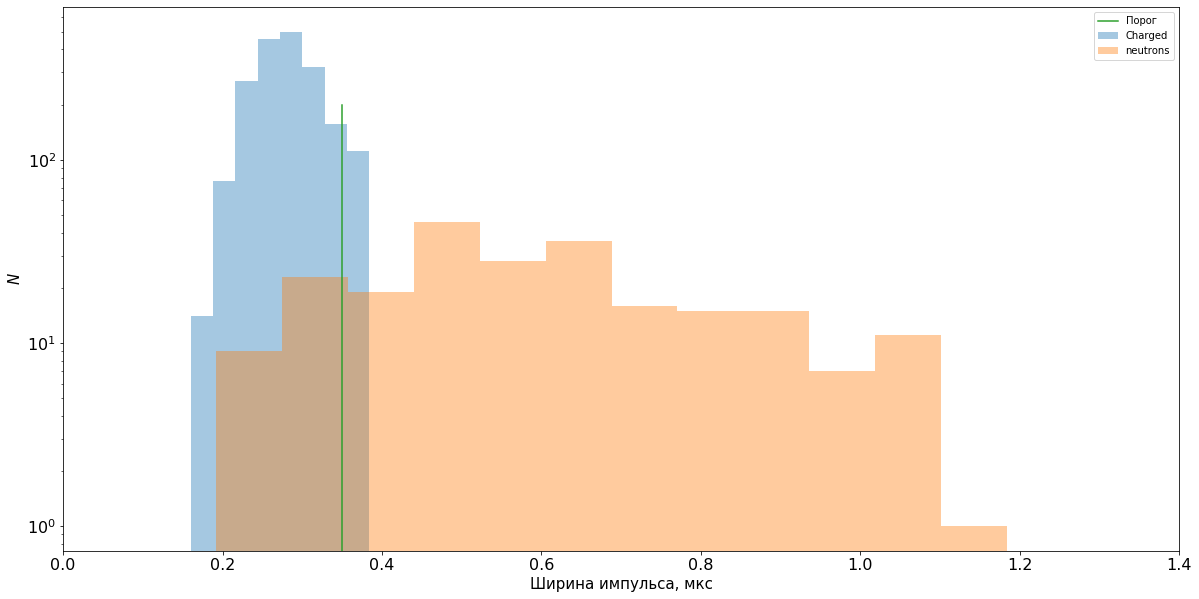

In [287]:
plt.figure(figsize=(20, 10))
sns.distplot(ch, kde=False, bins=8, label='Charged')
sns.distplot(n, kde=False, bins=12, label='neutrons')
plt.plot(([0.35, 0.35]),([0, 200]), label='Порог')
plt.yscale('log')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0, 1.4)
plt.legend()
plt.xlabel('Ширина импульса, мкс', fontsize = 15)
plt.ylabel("$N$", fontsize = 15)

# Примеры заряженной

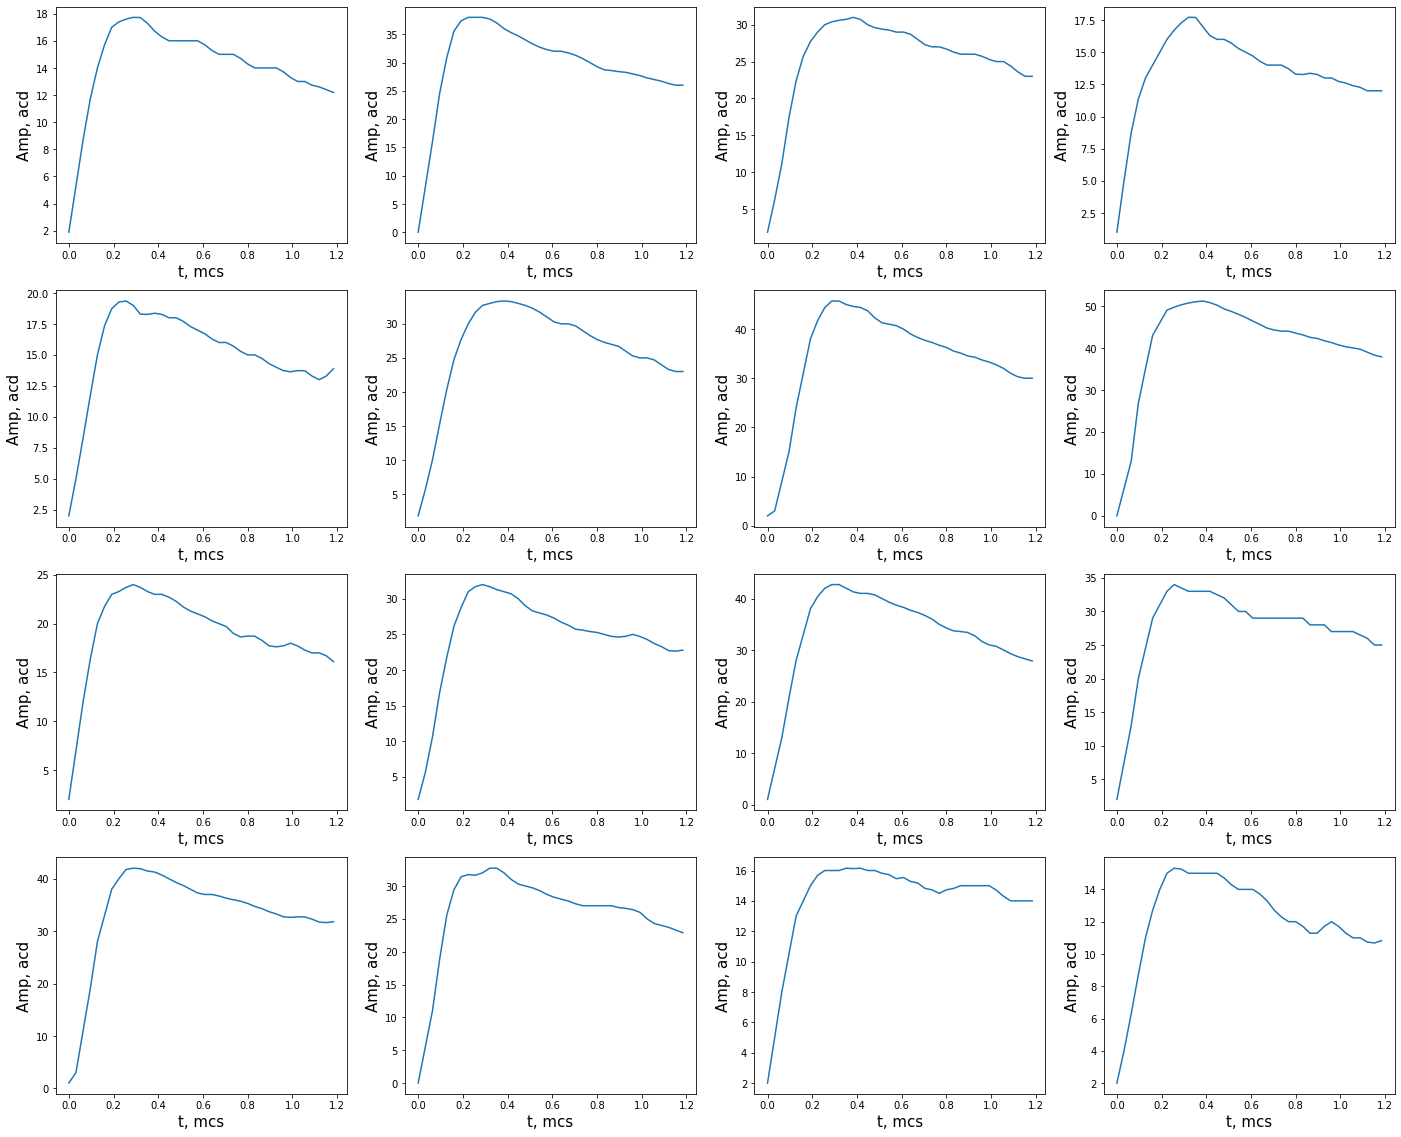

In [288]:
fig, axs = plt.subplots(4, 4, figsize=(24, 20))
axs = axs.ravel()
x = np.arange(38)
#bin_count = 60
for j in range(16):
    axs[j].plot(x*32e-3, charged[j])
    axs[j].set_xlabel("t, mcs", fontsize = 15)
    axs[j].set_ylabel("Amp, acd", fontsize = 15)

# Примеры нейтронов

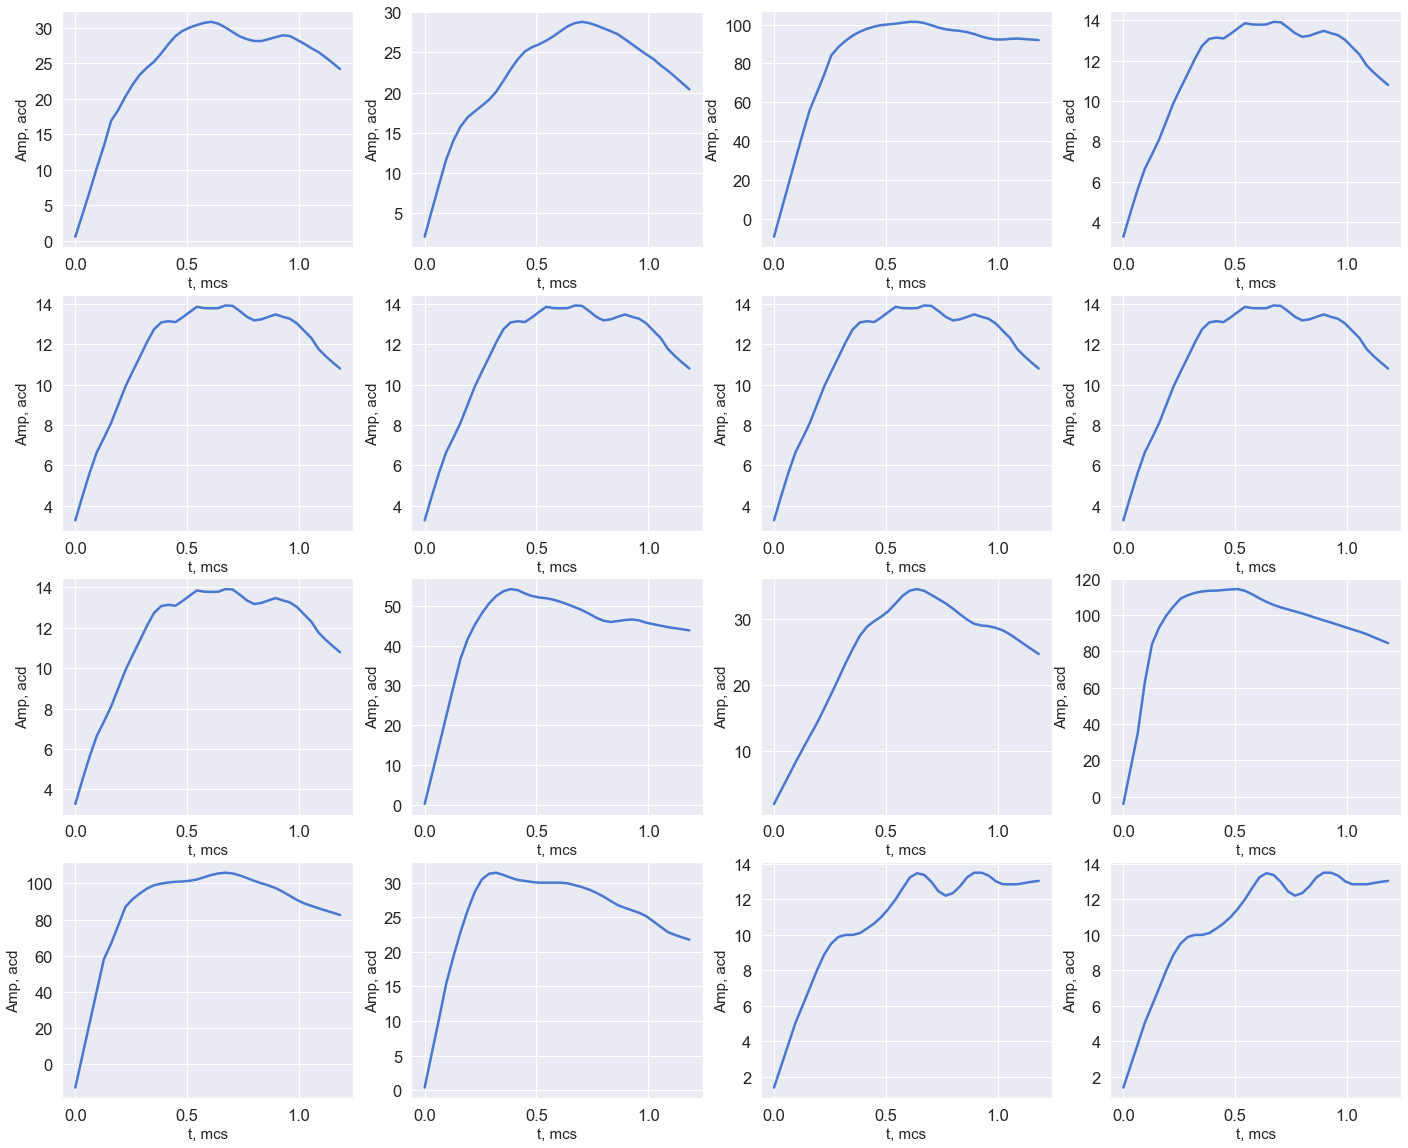

In [514]:
fig, axs = plt.subplots(4, 4, figsize=(24, 20))
axs = axs.ravel()
x = np.arange(38)
#bin_count = 60
for j in range(16):
    axs[j].plot(x*32e-3, neutron[j])
    axs[j].set_xlabel("t, mcs", fontsize = 15)
    axs[j].set_ylabel("Amp, acd", fontsize = 15)

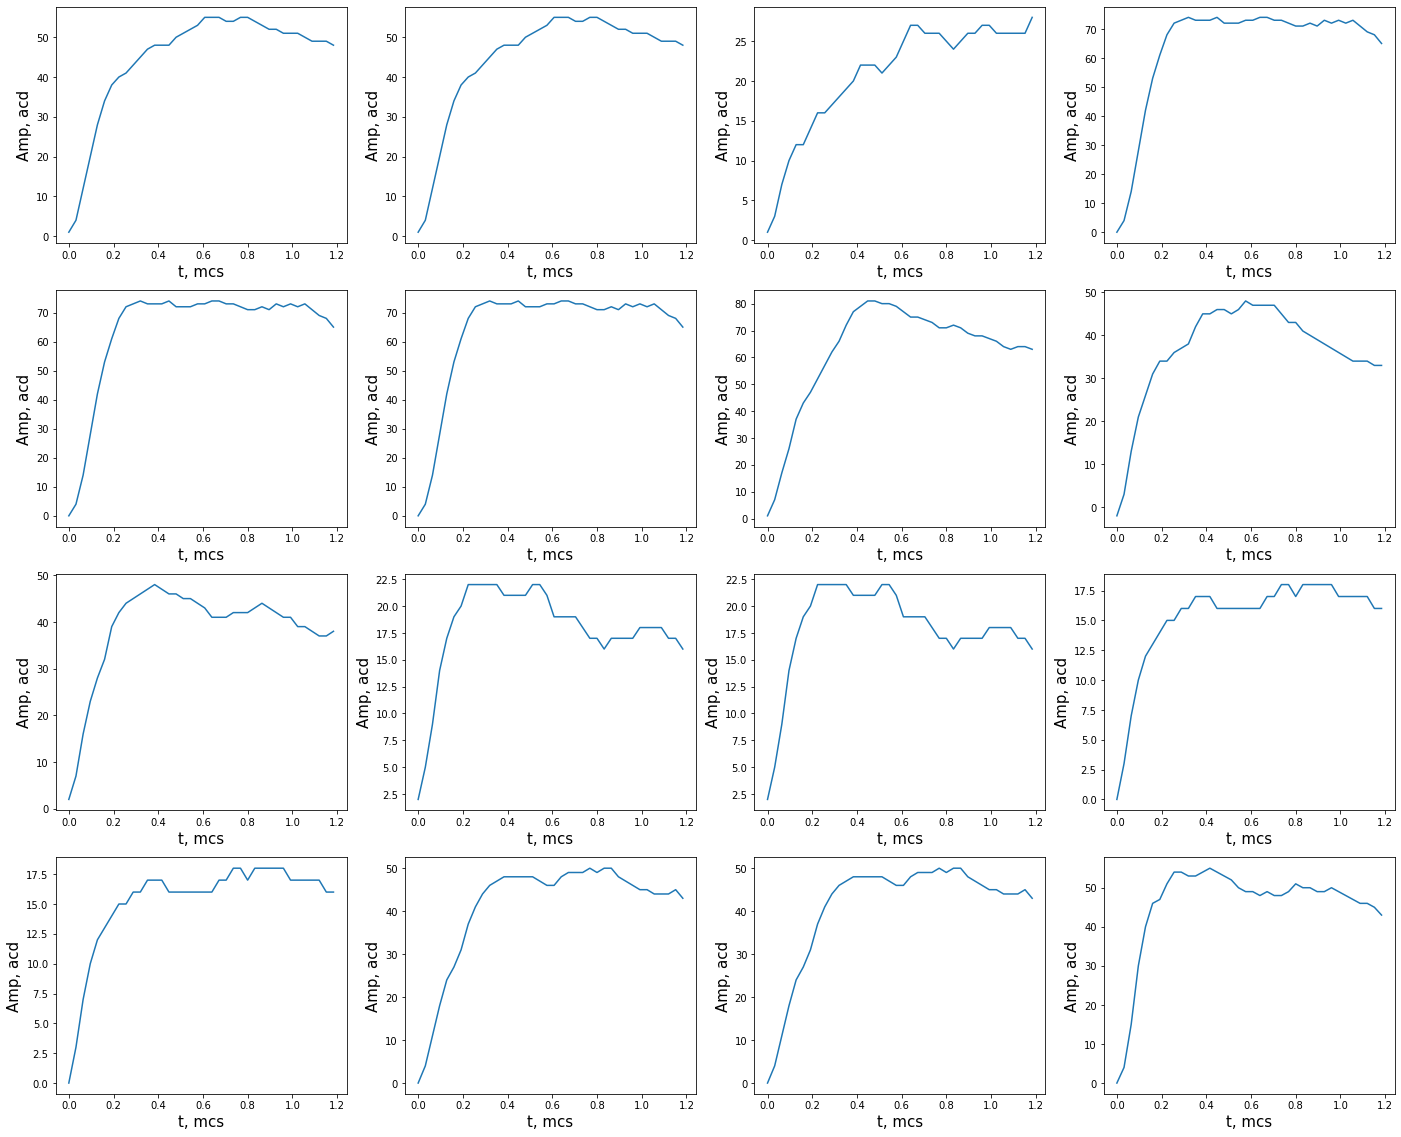

In [348]:
fig, axs = plt.subplots(4, 4, figsize=(24, 20))
axs = axs.ravel()
x = np.arange(38)
#bin_count = 60
for j in range(16):
    axs[j].plot(x*32e-3, neutron[j+15])
    axs[j].set_xlabel("t, mcs", fontsize = 15)
    axs[j].set_ylabel("Amp, acd", fontsize = 15)

In [446]:
charged.shape, neutron.shape, X.shape, y.shape

((900, 38), (226, 38), (1126, 38), (1126,))

# Векторное представление данных

In [442]:
import numpy as np
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold import TSNE
import seaborn as sns
RS = 2015
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt 
#%matplotlib inline

sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
rc={"lines.linewidth": 2.5})

In [447]:
y_tsne = np.copy(y)
y_tsne = y_tsne.reshape(y_tsne.shape[0])

In [458]:
osc_proj = TSNE(random_state=RS,perplexity=50.0).fit_transform(X)

In [463]:
def scatter(x, colors):
    palette = np.array(sns.color_palette("hls", 2))
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=10,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    txts = []
    for i in range(2):
        # Позиция для каждой метки
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

C:\Users\ASUS Zephyrus\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


(<Figure size 576x576 with 1 Axes>,
 [Text(-0.68568635, -16.358566, '0'), Text(-3.2244241, 6.1302557, '1')])

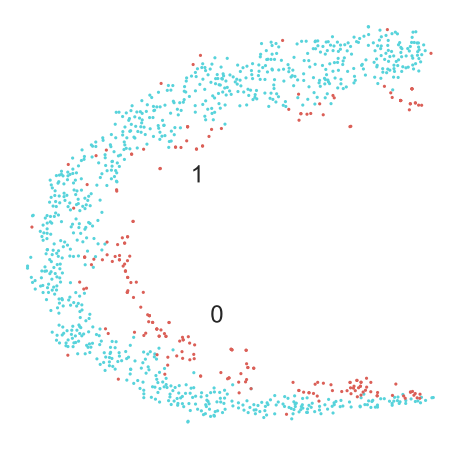

In [464]:
scatter(osc_proj, y_tsne)

# Нормировка

In [95]:
for i in range(neutron.shape[0]):
    neutron[i]/=np.max(neutron[i])
for i in range(charged.shape[0]):
    charged[i]/=np.max(charged[i])

In [170]:
np.max(charged)

1.0

In [29]:
charged.shape, neutron.shape

((1000, 38), (223, 38))

# train/test

In [393]:
X = np.concatenate((charged, neutron), axis = 0)
X.shape

(1126, 38)

In [394]:
X1 = np.copy(X)

X1 = X1[:, :, np.newaxis]
X1 = np.expand_dims(X1, 1) 
X1 = X1.reshape((X1.shape[0],1, 38))
X1 = np.array(X1, dtype=float)
X1.shape

(1126, 1, 38)

In [539]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3, random_state=17)

In [540]:
X_tr = torch.Tensor(X_train) # transform to torch tensor
y_tr = torch.Tensor(y_train)
y_tr = y_tr.type(torch.LongTensor)
X_ts = torch.Tensor(X_test)
y_ts = torch.Tensor(y_test)
y_ts = y_ts.type(torch.LongTensor)


train_ds = TensorDataset(X_tr, y_tr) # create your datset
train_dl = DataLoader(train_ds) # create your dataloader
test_ds = TensorDataset(X_ts, y_ts) 
test_dl = DataLoader(test_ds)

In [541]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

In [399]:
class CNN(torch.nn.Module):
    @property
    def device(self):
        for p in self.parameters():
            return p.device
        
    def __init__(self):
        super(CNN, self).__init__()
        
        #shape (1, 38)
        
        self.layers = torch.nn.Sequential()
        self.layers.add_module('conv1', torch.nn.Conv1d(1, 12, kernel_size = 3, stride=1, padding = 1)) # 1x38
        self.layers.add_module('relu1', torch.nn.ReLU())
        self.layers.add_module('dropout2', nn.Dropout(0.3))
        self.layers.add_module('maxpool1', torch.nn.MaxPool1d(2))
        self.layers.add_module('conv2', torch.nn.Conv1d(12, 20, kernel_size = 3, padding = 1)) # 12x19
        self.layers.add_module('relu2', torch.nn.ReLU())
        self.layers.add_module('dropout2', nn.Dropout(0.3))
        self.layers.add_module('maxpool2', torch.nn.MaxPool1d(2))        #20x9
        
        self.layers.add_module('flatten', torch.nn.Flatten())
        self.layers.add_module('linear1', torch.nn.Linear(20*9, 120))
        self.layers.add_module('relu3', torch.nn.ReLU())
        self.layers.add_module('dropout1', nn.Dropout(0.3))
        self.layers.add_module('linear2', torch.nn.Linear(120, 84))
        self.layers.add_module('relu4', torch.nn.ReLU())
        self.layers.add_module('dropout2', nn.Dropout(0.3))
        self.layers.add_module('linear3', torch.nn.Linear(84, 2))

    def forward(self, input):
        return self.layers(input)

In [469]:
class Net(nn.Module):    # kaggle 0.995 accuracy
    def __init__(self):
        super(Net, self).__init__()
          
        self.features = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Conv1d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
          
        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(64 * 9, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 2),
        )
          
        for m in self.features.children():
            if isinstance(m, nn.Conv1d):
                n = m.kernel_size[0] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
        for m in self.classifier.children():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x     

In [542]:
#model = CNN()
model = Net()
model.to(device)
model

C:\Users\ASUS Zephyrus\anaconda3\lib\site-packages\ipykernel_launcher.py:45: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Net(
  (features): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (8): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (11): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5

In [543]:
batch_generator = torch.utils.data.DataLoader(dataset = test_ds, 
                                              batch_size=32)          
pred = []
real = []
test_loss = 0
for it, (x_batch, y_batch) in enumerate(batch_generator):
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    output = model(x_batch)
    #output = output.squeeze_()

    test_loss += loss_function(output, y_batch).cpu().item()*len(x_batch) #.squeeze_()

    pred.extend(torch.argmax(output, dim=-1).cpu().numpy().tolist())
    real.extend(y_batch.cpu().numpy().tolist())

test_loss /= len(test_ds)

print('loss: {}'.format(test_loss))

loss: 0.8248760262889975


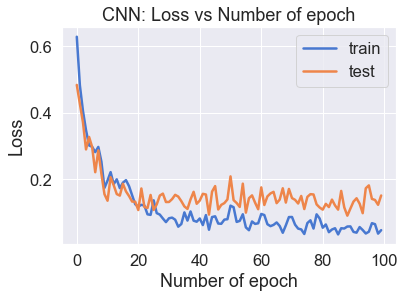

In [544]:
trainer(count_of_epoch = 100,
        batch_size = 32,
        dataset = train_ds,
        model = model,
        loss_function = loss_function,
        optimizer = optimizer,
        lr = 0.001,
        weight_decay=1e-5,
        callback = None)

In [545]:
batch_generator = torch.utils.data.DataLoader(dataset = test_ds, 
                                              batch_size=32)          
pred = []
real = []
test_loss = 0
for it, (x_batch, y_batch) in enumerate(batch_generator):
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    output = model(x_batch)
    #output = output.squeeze_()

    test_loss += loss_function(output, y_batch).cpu().item()*len(x_batch) #.squeeze_()

    pred.extend(torch.argmax(output, dim=-1).cpu().numpy().tolist())
    real.extend(y_batch.cpu().numpy().tolist())

test_loss /= len(test_ds)

print('loss: {}'.format(test_loss))

loss: 0.16309542936333538


In [546]:
pred = torch.argmax(model(X_ts), dim=-1).cpu().numpy()

In [477]:
# с новой моделью
from sklearn.metrics import classification_report
y_true = y_test
y_pred = pred
target_names = ['neutron','charged']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     neutron       0.94      0.94      0.94        66
     charged       0.99      0.99      0.99       272

    accuracy                           0.98       338
   macro avg       0.96      0.96      0.96       338
weighted avg       0.98      0.98      0.98       338



In [313]:
# Полная выборка без нормировки
y_true = y_test
y_pred = pred
target_names = ['neutron','charged']
print(classification_report(y_true, y_pred, target_names=target_names))
#precision_recall_fscore_support(y_test, pred, average='macro')

              precision    recall  f1-score   support

     neutron       0.97      0.88      0.92        76
     charged       0.98      1.00      0.99       563

    accuracy                           0.98       639
   macro avg       0.98      0.94      0.96       639
weighted avg       0.98      0.98      0.98       639



In [350]:
# без нормировки с уменьшенной выборкой
from sklearn.metrics import classification_report
y_true = y_test
y_pred = pred
target_names = ['neutron','charged']
print(classification_report(y_true, y_pred, target_names=target_names))
precision_recall_fscore_support(y_test, pred, average='macro')

              precision    recall  f1-score   support

     neutron       0.94      0.93      0.94       104
     charged       0.98      0.98      0.98       302

    accuracy                           0.97       406
   macro avg       0.96      0.96      0.96       406
weighted avg       0.97      0.97      0.97       406



(0.9593226312922555, 0.9564123790117167, 0.9578552321635326, None)

In [431]:
torch.save(model, 'F:\\1.New\\nets\\cnn_1d_n2')

In [275]:
import time
start_time = time.time()
pred = torch.argmax(model(X_ts), dim=-1).cpu().numpy()
print("--- %s seconds ---" % (time.time() - start_time))
pred.shape

--- 0.03193259239196777 seconds ---


(769,)

In [31]:
0.40355515480041504/0.014649629592895508

27.547123443730165

In [314]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3, random_state=17)
X_test.shape

(639, 1, 38)

In [408]:
k = np.argmax(X_test,axis=2)

In [410]:
un, count = np.unique(y_test, return_counts=True)
un, count

(array([0, 1]), array([ 66, 272], dtype=int64))

In [411]:
ch = np.zeros(272)
n = np.zeros(66)

kk = 0
kkk = 0
for i in range(k.shape[0]):
    if(y_test[i]==1):
        ch[kk] = k[i]*32e-3
        kk+=1
    else:
        n[kkk] = k[i]*32e-3
        kkk+=1

C:\Users\ASUS Zephyrus\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '$N$')

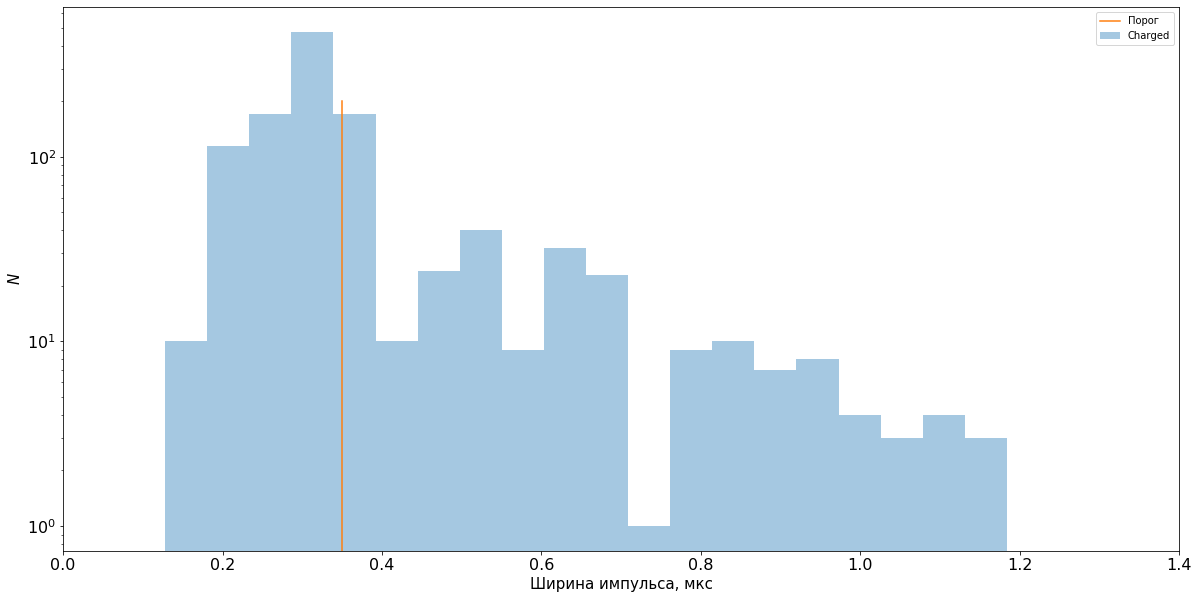

In [433]:
#np.argmax(X_test,axis=2)
plt.figure(figsize=(20, 10))
sns.distplot(np.argmax(X1,axis=2)*32e-3, kde=False, bins=20, label='Charged')
plt.plot(([0.35, 0.35]),([0, 200]), label='Порог')
plt.yscale('log')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0, 1.4)
plt.legend()
plt.xlabel('Ширина импульса, мкс', fontsize = 15)
plt.ylabel("$N$", fontsize = 15)

In [426]:
pred1 = np.zeros(pred.shape[0])
tr = 0
rec = []
best_pres = 0
best_recall = 0
best_f1 = 0
for j in np.arange(0.1,0.6, 0.01):
    for i in range(pred.shape[0]):
        k = np.argmax(X_test[i])
        if((np.argmax(X_test[i]))*32e-3 < j):
            pred1[i] = 1
        else:
            pred1[i] = 0
    rec.append(precision_recall_fscore_support(y_test, pred1, average='macro')[1])
    if(best_recall < precision_recall_fscore_support(y_test, pred1, average='macro')[1] and best_f1 < precision_recall_fscore_support(y_test, pred1, average='macro')[2]):
        best_pres = precision_recall_fscore_support(y_test, pred1, average='macro')[0]
        best_recall = precision_recall_fscore_support(y_test, pred1, average='macro')[1]
        best_f1 = precision_recall_fscore_support(y_test, pred1, average='macro')[2]
        tr = j
rec = np.array(rec)
best_pres, best_recall, best_f1, tr

(0.9236301923387749,
 0.9380013368983957,
 0.9305812281782707,
 0.3599999999999999)

In [505]:
pred1 = np.zeros(pred.shape[0])
for i in range(pred.shape[0]):
    k = np.argmax(X_test[i])
    if((np.argmax(X_test[i]))*32e-3 < 0.36):
        pred1[i] = 1
    else:
        pred1[i] = 0
precision_recall_fscore_support(y_test, pred1, average='macro')

(0.9236301923387749, 0.9380013368983957, 0.9305812281782707, None)

In [ ]:
# 0.9788732394366197, 0.9090909090909092, 0.9392086330935252

#     neutron       0.94      0.94      0.94        66
#     charged       0.99      0.99      0.99       272

#    accuracy                           0.98       338
#   macro avg       0.96      0.96      0.96       338
#weighted avg       0.98      0.98      0.98       338

In [506]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, pred)) # CNN
print(roc_auc_score(y_test, pred1)) # front

0.9623440285204993
0.9380013368983956


In [511]:
from sklearn.metrics import precision_recall_fscore_support
y_true = y_test
y_pred = pred1
precision_recall_fscore_support(y_true, y_pred, average='macro'),precision_recall_fscore_support(y_true, pred, average='macro')

((0.9236301923387749, 0.9380013368983957, 0.9305812281782707, None),
 (0.9623440285204992, 0.9623440285204992, 0.9623440285204992, None))

[[ 60   6]
 [  9 263]]
[[ 62   4]
 [  4 268]]


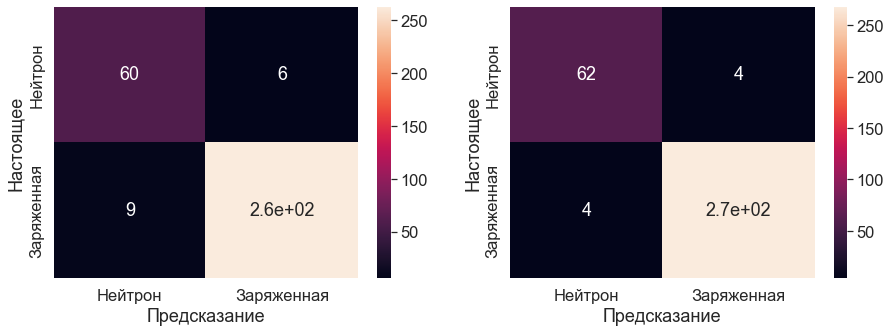

In [512]:
# для модели с kaggle
plt.figure(figsize=(15, 5))
x_l = ['Нейтрон', 'Заряженная']
y_l = ['Нейтрон', 'Заряженная']
plt.subplot(1, 2, 1)
cf_matrix = confusion_matrix(y_test, pred1)
sns.heatmap(cf_matrix, annot=True,xticklabels=x_l, yticklabels=y_l)
plt.ylabel("Настоящее")
plt.xlabel("Предсказание")
print(cf_matrix)

plt.subplot(1, 2, 2)
cf_matrix = confusion_matrix(y_test, pred)
sns.heatmap(cf_matrix, annot=True,xticklabels=x_l, yticklabels=y_l)
plt.ylabel("Настоящее")
plt.xlabel("Предсказание")
print(cf_matrix)

[[ 88  16]
 [ 26 276]]
[[ 97   7]
 [  6 296]]


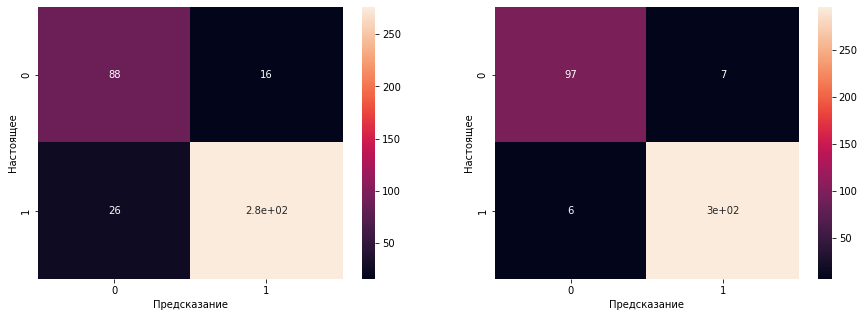

In [365]:
# для своей модели
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
cf_matrix = confusion_matrix(y_test, pred1)
sns.heatmap(cf_matrix, annot=True)
plt.ylabel("Настоящее")
plt.xlabel("Предсказание")
print(cf_matrix)

plt.subplot(1, 2, 2)
cf_matrix = confusion_matrix(y_test, pred)
sns.heatmap(cf_matrix, annot=True)
plt.ylabel("Настоящее")
plt.xlabel("Предсказание")
print(cf_matrix)

# Валидация

In [560]:
model1 = torch.load('F:\\1.New\\nets\\cnn_1d_n')
model1.eval()

CNN(
  (layers): Sequential(
    (conv1): Conv1d(1, 12, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu1): ReLU()
    (dropout2): Dropout(p=0.3, inplace=False)
    (maxpool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv1d(12, 20, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu2): ReLU()
    (maxpool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear1): Linear(in_features=180, out_features=120, bias=True)
    (relu3): ReLU()
    (dropout1): Dropout(p=0.3, inplace=False)
    (linear2): Linear(in_features=120, out_features=84, bias=True)
    (relu4): ReLU()
    (linear3): Linear(in_features=84, out_features=2, bias=True)
  )
)

In [551]:
mypath = 'C:\\Users\\ASUS Zephyrus\\Desktop\\INR\\data\\big_INR\\val\\'

onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
len(onlyfiles)

1

In [552]:
names = [name for i in range(1, 17) for name in ['d8_' + str(i), 'd5_' + str(i)]]
#time_f = []
ch = []
neutron = []

time_ch = []
time_n = []
time = []

for file in onlyfiles:
    osc = pd.read_csv(mypath+file, delim_whitespace=True, names=names, index_col=0)
    for det in range(1,17):
        peaks, _ = find_peaks(osc['d8_'+ str(det)],prominence=1, height=14, width=30) # height 7
        for i in range(100): #182
            if(peaks.shape[0]>i and det!=4):
                x=np.copy(osc['d8_'+ str(det)])
                k = peaks[i]
                while(x[k]>2):
                    k-=1
                if(i==0 and (peaks[i]- k)*0.032 <0.4):
                    ch.append(x[k:k+38])
                    time_ch.append((peaks[i]- k)*0.032)
                elif(i!=0 and (peaks[i]- k)*0.032 < 1.2 and peaks[i] > 3125):  # 100 мкс 
                    neutron.append(x[k:k+38])
                    time_n.append((peaks[i]- k)*0.032)

#charged = np.array(charged)
neutron = np.array(neutron)
time_ch = np.array(time_ch)
time_n = np.array(time_n)
charged.shape, neutron.shape

((900, 38), (31, 38))

In [553]:
neu = np.zeros((neutron.shape[0],38))
x = np.arange(0,38)
for i in range(neutron.shape[0]):
    y_lowess = sm.nonparametric.lowess(neutron[i], x, frac = 0.11)
    neu[i] = y_lowess[:,1]
neu.shape 

(31, 38)

In [554]:
neu = neu[:, :, np.newaxis]
neu = np.expand_dims(neu, 1) 
neu = neu.reshape((neu.shape[0],1, 38))
neu = np.array(neu, dtype=float)

In [555]:
neu.shape

(31, 1, 38)

In [561]:
X_ts = torch.Tensor(neu)
pred_v = torch.argmax(model1(X_ts), dim=-1).cpu().numpy()

In [562]:
y_true = np.zeros(neutron.shape[0])
y_pred = pred_v
target_names = ['neutron','charged']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     neutron       1.00      0.68      0.81        31
     charged       0.00      0.00      0.00         0

    accuracy                           0.68        31
   macro avg       0.50      0.34      0.40        31
weighted avg       1.00      0.68      0.81        31



In [563]:
pred_v

array([0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0], dtype=int64)

In [564]:
un, count = np.unique(pred_v, return_counts=True)
un, count

(array([0, 1], dtype=int64), array([21, 10], dtype=int64))

In [565]:
ffr = np.argmax(neutron,axis=1)
ffr.shape

(31,)

In [566]:
ffr*32e-3

array([0.512, 0.32 , 0.32 , 0.32 , 0.32 , 0.448, 0.448, 0.352, 0.544,
       0.448, 0.576, 0.576, 0.576, 0.448, 0.768, 0.608, 0.608, 1.184,
       0.32 , 0.32 , 0.32 , 0.448, 0.576, 0.384, 0.224, 0.224, 0.736,
       0.736, 0.768, 0.768, 0.416])

In [567]:
ffr = np.argmax(neutron,axis=1)
ff = ffr[ffr*32e-3>=0.36]
ff.shape, ffr.shape, ff.shape[0]/ffr.shape[0]

((21,), (31,), 0.6774193548387096)

In [568]:
X_tr.shape

torch.Size([788, 1, 38])

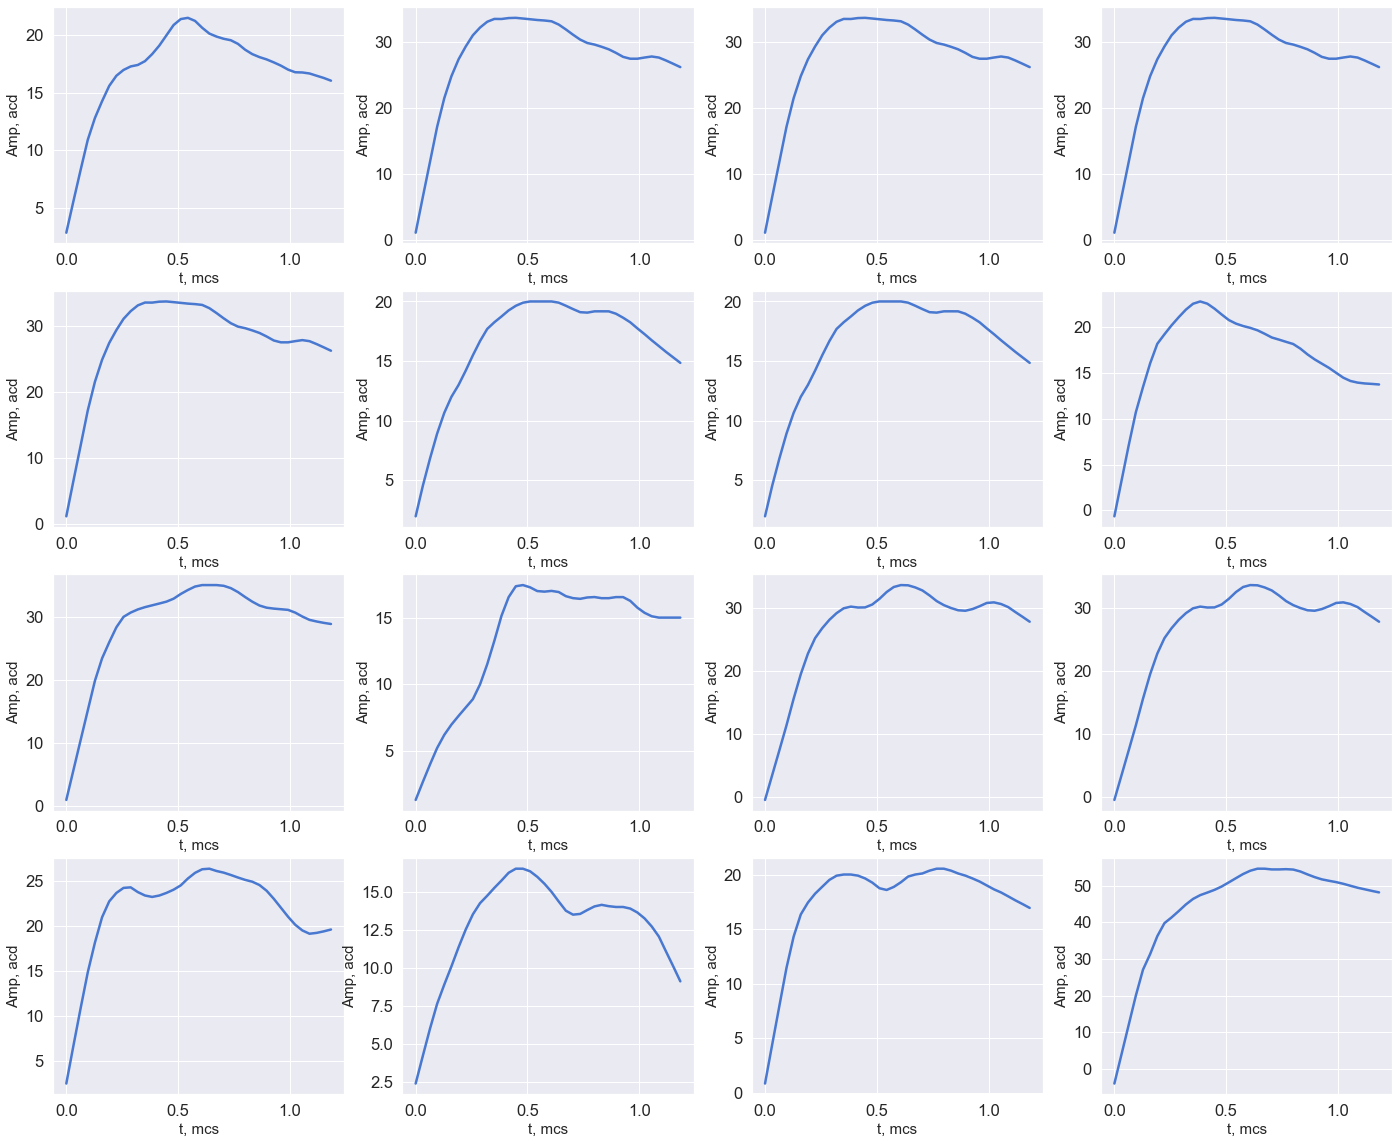

In [570]:
fig, axs = plt.subplots(4, 4, figsize=(24, 20))
axs = axs.ravel()
x = np.arange(38)
#bin_count = 60
for j in range(16):
    axs[j].plot(x*32e-3, neu[j][0])
    #axs[j].plot(x*32e-3, neu[j])
    axs[j].set_xlabel("t, mcs", fontsize = 15)
    axs[j].set_ylabel("Amp, acd", fontsize = 15)